### 사전준비

- parent directory 를 python library path에 추가하기

In [ ]:
# Parent directory의 .py 파일에 정의된 함수들를 import 하여 사용하기 위해 parent directory 를 python library path에 추가합니다.

import sys
import os

current_dir = os.getcwd()
print("Current Directory:", current_dir)

parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print("Parent Directory:", parent_dir)

sys.path.append(parent_dir)

# System Path 와는 다름
print("System PATH :", os.environ['PATH'])
print("Python Library PATH :", sys.path)

- mp4 file로부터 video array, 재생시간, frame개수 정보를 추출하기

In [ ]:
# ../functions.py 에 미리 정의된 함수들을 import 한다
from functions import video_2_ndarray

# 함수 video_2_ndarray 를 사용하여 ../media/SampleVideo_640x360_5mb.mp4 의 video data를 ndarray 에 저장한다.
# video array, 재생시간, frame 개수를 저장
video_array, tot_duration, tot_frames = video_2_ndarray('../media/SampleVideo_640x360_5mb.mp4')

- 연속되는 두 frame들간의 유사도를 구해서 차례로 list에 저장

In [ ]:
# numpy를 import 한다
import numpy as np

In [ ]:
from numpy import dot
from numpy.linalg import norm

# cosine similatiry 함수
def cos_sim(A, B):
    return dot(A, B) / (norm(A) * norm(B))

In [ ]:
prev_frame = None

similarity_list = []

for frame in video_array:

    # 1차원으로 reshape
    # 255로 나눔
    # 50간격으로 sampling
    current_vector = (frame.reshape(-1) / 255)[::50]
    
    if prev_frame is not None:
        similarity = cos_sim(prev_vector, current_vector)
        similarity_list.append(similarity)
            
    prev_frame = frame.copy()
    prev_vector = current_vector.copy()

print('vector size : ',current_vector.shape)
print('similarity_list : ',similarity_list)

### 따라 해보기 #1. pandas를 사용하여 ndarray 정보를 csv파일에 저장하기

- 2차원 이하의 array만 pandas DataFrame으로 변환될 수 있다. video array는 4차원이므로 불가

In [47]:
import pandas as pd

# DataFrame 생성
video_df = pd.DataFrame(video_array)

ValueError: Must pass 2-d input. shape=(489, 368, 640, 3)

- 4차원인 video array를 (height, width) = (0, 0)를 고정하여(2차원으로 변환하여) DataFrame 생성

In [53]:
# 첫 번째 픽셀의 RGB 값 가져오기
first_pixels = video_array[:, 0, 0, :]
print('first_pixels의 차원 : ', first_pixels.ndim)

np_df = pd.DataFrame(first_pixels, columns=['R', 'G', 'B'])

print(np_df)

first_pixels의 차원 :  2
     R  G  B
0    3  1  0
1    3  1  0
2    3  1  0
3    3  1  0
4    3  1  0
..  .. .. ..
484  2  3  6
485  2  3  6
486  2  1  4
487  1  0  2
488  1  0  2

[489 rows x 3 columns]


<Axes: >

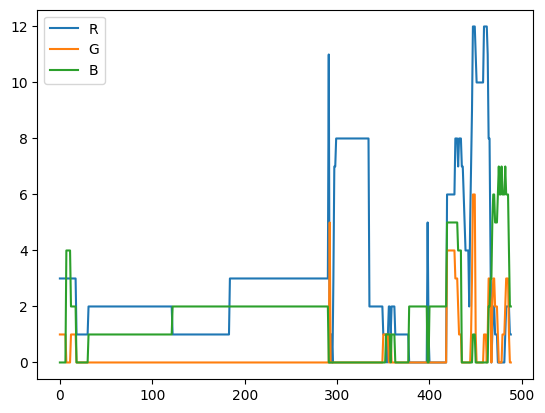

In [54]:
np_df.plot()

- DataFrame을 csv 파일로 내려 받기

In [55]:
csv = np_df.to_csv(path_or_buf = "first_pixels.csv", index=True)

### 따라 해보기 #2. pandas를 사용하여 영상 grouping 하기
- 유사도가 낮아지는 지점을 기준으로 grouping 하기

- 유사도 DataFrame 생성

In [ ]:
import pandas as pd

# DataFrame 생성
df = pd.DataFrame(similarity_list, columns=['similarity'])

print(df)

In [ ]:
df.plot()

- 특정 유사도 값을 기준으로 '낮은 유사도'와 '높은 유사도' 두그룹으로 분할해보기

In [ ]:
# 유사도 임계치 설정
lower_sim_threshold = 0.95

In [ ]:
# groupby 기준이 조건식이면 True와 False 두개로 grouping 된다.
dfg = df.groupby((df['similarity'] < lower_sim_threshold))

for group_number, group_df in dfg:
    print('Group Name : ', group_number)
    print('Group Members : ', group_df)

In [ ]:
dfg.plot()

- 유사도 DataFrame에 2개 칼럼 추가
	- lower_sim : 유사도 임계치 이하 여부
	- cumsum : lower_sim의 누적 합계

In [ ]:
# 출력 시 '...' 없이 전체 출력
pd.set_option('display.max_rows', None)

# 유사도가 임계치 이하면 True(1) 아니면 False(0)
df['lower_sim'] = (df['similarity'] < lower_sim_threshold)

#lower_sim의 누적합(Cumulative Sum)을 구함
df['cumsum'] = df['lower_sim'].cumsum()

# df 출력
print(df)

# 출력 시 30 rows 출력 후 '...' 처리
pd.set_option('display.max_rows', 30)

In [ ]:
df.plot()

- cumsum 을 기준으로 grouping
    - 결과적으로 유사도가 낮은 순간(lower_sim_threshold 보다 작은 순간) group이 분할됨

In [ ]:
dfg = df.groupby(df['cumsum'])

for group_number, group_df in dfg:
    print('Group Name : ', group_number)
    print('Group Members : ', group_df)

In [ ]:
dfg.plot()

- Group별 시작 frame 번호, 종료 frame 번호, group 분할 시점의 유사도 조회

In [34]:
for group_number, group_df in dfg:
    min_frame_number = group_df.index.min()+1
    max_frame_number = group_df.index.max()+1
    min_similarity = group_df['similarity'].min()
    print(group_number, min_frame_number, max_frame_number, min_similarity)

0 1 30 0.9770964243246925
1 31 121 0.804662909689668
2 122 183 0.9375795879362757
3 184 286 0.8453070395907233
4 287 296 0.9473107266428288
5 297 334 0.8589918794939202
6 335 377 0.7406269448657592
7 378 418 0.6808655525334377
8 419 488 0.7718479796650425


- Group 정보 DataFrame 생성
    - 사전준비 단계에서 구했던 tot_duration(재생시간), tot_frames(frame 개수) 사용하여 frame개수, 시작시간, 재생시간 항목 추가

In [40]:
# 사전준비 단계에 구했던 tot_duration(재생시간), tot_frames(frame 개수) 사용

groups = []

for group_number, group_df in dfg:

    min_frame_number = group_df.index.min()+1
    max_frame_number = group_df.index.max()+1
    min_similarity = group_df['similarity'].min()

    frame_count = max_frame_number - min_frame_number + 1
    start = tot_duration*(min_frame_number/tot_frames)
    duration = tot_duration*(frame_count/tot_frames)

    groups.append({
        'group_number': group_number,
        'group_name': f"Take #{group_number}",
        'min_frame_number': min_frame_number,
        'max_frame_number': max_frame_number,
        'frame_count' : frame_count,
        'start' : "{:.2f}".format(start),
        'duration' : "{:.2f}".format(duration),
        'min_similarity': min_similarity
    })

# group 정보로 DataFrame 생성
group_df = pd.DataFrame(groups)

print(group_df)

   group_number group_name  min_frame_number  max_frame_number  frame_count  \
0             0    Take #0                 1                30           30   
1             1    Take #1                31               121           91   
2             2    Take #2               122               183           62   
3             3    Take #3               184               286          103   
4             4    Take #4               287               296           10   
5             5    Take #5               297               334           38   
6             6    Take #6               335               377           43   
7             7    Take #7               378               418           41   
8             8    Take #8               419               488           70   

   start duration  min_similarity  
0   0.05     1.50        0.977096  
1   1.55     4.55        0.804663  
2   6.10     3.10        0.937580  
3   9.20     5.15        0.845307  
4  14.35     0.50        0.94

- (선택) Group 정보 DataFrame 생성 - column 이름 나중에 지정

In [38]:
# 사전준비 단계에 구했던 tot_duration(재생시간), tot_frames(frame 개수) 사용

groups = []

for group_number, group_df in dfg:

    min_frame_number = group_df.index.min()+1
    max_frame_number = group_df.index.max()+1
    min_similarity = group_df['similarity'].min()

    frame_count = max_frame_number - min_frame_number + 1
    start = tot_duration*(min_frame_number/tot_frames)
    duration = tot_duration*(frame_count/tot_frames)

    groups.append([
        group_number,
        f"Take #{group_number}",
        min_frame_number,
        max_frame_number,
        frame_count,
        "{:.2f}".format(start),
        "{:.2f}".format(duration),
        min_similarity
    ])

# group 정보로 DataFrame 생성
columns=['Seq','장면이름','시작 frame 번호','종료 frame 번호','frame개수','시작시간','재생시간','Take 전환 시 유사도']

group_df2 = pd.DataFrame(groups, columns=columns)

print(group_df2)

   Seq     장면이름  시작 frame 번호  종료 frame 번호  frame개수   시작시간  재생시간  Take 전환 시 유사도
0    0  Take #0            1           30       30   0.05  1.50       0.977096
1    1  Take #1           31          121       91   1.55  4.55       0.804663
2    2  Take #2          122          183       62   6.10  3.10       0.937580
3    3  Take #3          184          286      103   9.20  5.15       0.845307
4    4  Take #4          287          296       10  14.35  0.50       0.947311
5    5  Take #5          297          334       38  14.85  1.90       0.858992
6    6  Take #6          335          377       43  16.75  2.15       0.740627
7    7  Take #7          378          418       41  18.90  2.05       0.680866
8    8  Take #8          419          488       70  20.95  3.50       0.771848


- DataFrame을 csv파일에 저장

In [42]:
csv = group_df.to_csv(path_or_buf = "video_grouping.csv", 
                      columns=['group_name', 'frame_count', 'start', 'duration', 'min_frame_number', 'max_frame_number', 'min_similarity'], 
                      index=False)